In [1]:
import pandas as pd
import numpy as np
data = pd.read_csv('RedditTokenized.csv')
data.head()

,comment,hate_speech,tokens,word2vec_vector,text,label
0,A subsection of retarded Hungarians? Oh boy. b...,1,"['a', 'subsection', 'of', 'retarded', 'hungari...",[-0.01025309 0.10916914 0.06691193 -0.583091...,a subsection of retarded hungarians ? oh boy ....,__label__1
1,Iii. Just got off work. Foundation and groundi...,0,"['iii', '.', 'just', 'got', 'off', 'work', '.'...",[ 0.01866228 0.12514791 0.12122827 -0.047967...,iii . just got off work . foundation and groun...,__label__0
2,wow i guess cowboys are the same in every country,0,"['wow', 'i', 'guess', 'cowboys', 'are', 'the',...",[ 0.14951295 0.2422072 0.15283646 0.170495...,wow i guess cowboys are the same in every country,__label__0
3,Owen Benjamin's cowboy song goes for every cou...,0,"['owen', 'benjamin', ""'s"", 'cowboy', 'song', '...",[-3.88697950e-02 3.65950141e-01 -1.04890444e-...,owen benjamin 's cowboy song goes for every co...,__label__0
4,"> ""y'all hear sun?"" by all means I live in a s...",0,"['>', '``', ""y'all"", 'hear', 'sun', '?', ""''"",...",[ 0.06908988 0.07478161 0.11669861 -0.296530...,> `` y'all hear sun ? '' by all means i live i...,__label__0


In [2]:
import fasttext
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Train a FastText supervised model
model = fasttext.train_supervised(input='train.txt', epoch=10, lr=0.1, wordNgrams=2, bucket=200000, dim=100, loss='ova')

# Evaluate the model
def evaluate_model(model, test_file):
    with open(test_file, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    y_true = []
    y_pred = []
    for line in lines:
        label, text = line.strip().split(' ', 1)
        y_true.append(int(label.replace('__label__', '')))
        pred_label, _ = model.predict(text)
        y_pred.append(int(pred_label[0].replace('__label__', '')))

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1:.4f}')

# Call the evaluate_model function
evaluate_model(model, 'test.txt')


Accuracy: 0.8735
Precision: 0.8630
Recall: 0.5852
F1-score: 0.6975


## Analysis of Performance
- #### High Accuracy with Low Recall:

##### Your model has a high accuracy but a relatively low recall. This often implies that the dataset might be imbalanced, with a majority of non-hate speech examples.
##### The model might be biased towards predicting the majority class (non-hate speech), leading to more false negatives (actual hate speech classified as non-hate speech).
- #### High Precision:

##### The high precision indicates that when the model predicts hate speech, it is usually correct. This is good for reducing false alarms, but it comes at the cost of not catching many true hate speech cases.

## Improving model

#### Techniques for Handling Imbalanced Data
- ##### Class Weighting
- ##### Resampling Techniques
  Oversampling: SMOTE, ADASYN
  
  Undersampling: Random undersampling
- ##### Algorithmic Approaches
  Ensemble Methods: Balanced Random Forest, EasyEnsemble
- ##### Performance Metrics
  Using metrics suitable for imbalanced datasets: Precision, Recall, F1-score, AUC-ROC

In [3]:
#Data Preparation
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

data['label'] = data['label'].map({'__label__1': 1, '__label__0': 0})

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.2, random_state=42)

# Vectorizing text data
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [4]:
#class weighting
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

class_weights = compute_class_weight('balanced', classes=[0, 1], y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

model_weighted = RandomForestClassifier(class_weight=class_weight_dict, random_state=42)
model_weighted.fit(X_train_tfidf, y_train)
y_pred_weighted = model_weighted.predict(X_test_tfidf)

print("Class Weighting:\n", classification_report(y_test, y_pred_weighted))


Class Weighting:
               precision    recall  f1-score   support

           0       0.83      0.98      0.90      3341
           1       0.90      0.41      0.57      1109

    accuracy                           0.84      4450
   macro avg       0.87      0.70      0.73      4450
weighted avg       0.85      0.84      0.82      4450



In [5]:
#SMOTE (Oversampling)

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

model_smote = RandomForestClassifier(random_state=42)
model_smote.fit(X_train_resampled, y_train_resampled)
y_pred_smote = model_smote.predict(X_test_tfidf)

print("SMOTE:\n", classification_report(y_test, y_pred_smote))


SMOTE:
               precision    recall  f1-score   support

           0       0.84      0.97      0.90      3341
           1       0.83      0.45      0.59      1109

    accuracy                           0.84      4450
   macro avg       0.84      0.71      0.74      4450
weighted avg       0.84      0.84      0.82      4450



In [6]:
#Random Undersampling
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_tfidf, y_train)

model_rus = RandomForestClassifier(random_state=42)
model_rus.fit(X_train_resampled, y_train_resampled)
y_pred_rus = model_rus.predict(X_test_tfidf)

print("Random Undersampling:\n", classification_report(y_test, y_pred_rus))


Random Undersampling:
               precision    recall  f1-score   support

           0       0.93      0.89      0.91      3341
           1       0.70      0.80      0.75      1109

    accuracy                           0.86      4450
   macro avg       0.81      0.84      0.83      4450
weighted avg       0.87      0.86      0.87      4450



In [7]:
#Balanced Random Forest
from imblearn.ensemble import BalancedRandomForestClassifier

model_brf = BalancedRandomForestClassifier(random_state=42)
model_brf.fit(X_train_tfidf, y_train)
y_pred_brf = model_brf.predict(X_test_tfidf)

print("Balanced Random Forest:\n", classification_report(y_test, y_pred_brf))


C:\Anaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Anaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


Balanced Random Forest:
               precision    recall  f1-score   support

           0       0.93      0.89      0.91      3341
           1       0.71      0.79      0.75      1109

    accuracy                           0.87      4450
   macro avg       0.82      0.84      0.83      4450
weighted avg       0.87      0.87      0.87      4450



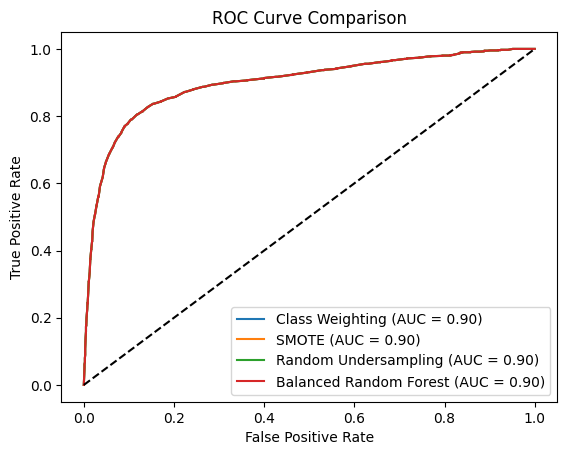

In [8]:
#for comparison
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

methods = {
    'Class Weighting': y_pred_weighted,
    'SMOTE': y_pred_smote,
    'Random Undersampling': y_pred_rus,
    'Balanced Random Forest': y_pred_brf
}

# Calculate and print ROC-AUC for each method
for method_name, y_pred in methods.items():
    y_probs = model_brf.predict_proba(X_test_tfidf)[:, 1]
    auc = roc_auc_score(y_test, y_probs)
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    plt.plot(fpr, tpr, label=f'{method_name} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='best')
plt.show()


### An AUC of 0.90 is quite high, suggesting that model perform well overall in differentiating between classes. This is a positive indicator for the effectiveness of the methods in handling class imbalance.